# Transformers and Attention

## Librairies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Task: "Predict symbol after last A"

- On donne une séquence de lettres (par ex. [B, A, C, A, D]);
- On veut prédire le symbole juste après le dernier "A" (ici D);
- S’il n’y a pas de "A", on retourne un symbole par défaut (A dans notre cas).

Un Recurrent Neural Network (RNN) ou Multi Layer Perceptron (MLP) séquentiel doit parcourir la séquence entière et "mémoriser" où se trouve le dernier A. C’est possible, mais difficile à apprendre et lent à converger.

Un modèle à **self-attention** peut, au contraire, apprendre très vite à "pointer" directement vers la dernière position contenant A, puis "regarder" le symbole juste après ce dernier A.

## Dataset

- Génération du dataset

In [335]:
VOCAB = ["A", "B", "C", "D", "E"]
VOCAB_SIZE = len(VOCAB)
CHAR_TO_IDX = {ch: i for i, ch in enumerate(VOCAB)}
IDX_TO_CHAR = {i: ch for ch, i in CHAR_TO_IDX.items()}

# Pour les petites séquences, le MLP marche très bien...
SEQ_LEN = 20  # longueur des séquences
N_SAMPLES = 2000

In [336]:
def generate_example():
    seq = [random.choice(VOCAB) for _ in range(SEQ_LEN)]
    # trouver la dernière occurrence de 'A'
    if "A" in seq and seq.index("A") != len(seq) - 1:
        last_idx = max(i for i, x in enumerate(seq) if x == "A")
        if last_idx < len(seq) - 1:
            target = seq[last_idx + 1]
        else:
            target = "A"
    else:
        target = "A"
    return seq, target

In [337]:
generate_example()

(['B',
  'E',
  'A',
  'A',
  'E',
  'D',
  'C',
  'D',
  'E',
  'A',
  'D',
  'A',
  'A',
  'E',
  'B',
  'A',
  'A',
  'D',
  'B',
  'D'],
 'D')

In [338]:
def generate_dataset(n=N_SAMPLES):
    data, labels = [], []
    for _ in range(n):
        seq, tgt = generate_example()
        data.append([CHAR_TO_IDX[c] for c in seq])
        labels.append(CHAR_TO_IDX[tgt])
    return torch.tensor(data), torch.tensor(labels)

In [339]:
train_x, train_y = generate_dataset(1500)
test_x, test_y = generate_dataset(500)

In [340]:
train_x, train_y

(tensor([[1, 3, 0,  ..., 2, 0, 4],
         [2, 0, 2,  ..., 2, 1, 1],
         [2, 3, 0,  ..., 3, 0, 2],
         ...,
         [2, 1, 2,  ..., 0, 2, 0],
         [1, 3, 0,  ..., 4, 4, 1],
         [2, 3, 4,  ..., 0, 0, 1]]),
 tensor([4, 3, 2,  ..., 0, 1, 1]))

## Models

In [341]:
EMBED_DIM = 32  # embedding plus grand
HIDDEN_DIM = 64

In [348]:
# --- Simple MLP (no attention) --- #

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        self.fc1 = nn.Linear(SEQ_LEN * EMBED_DIM, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, VOCAB_SIZE)

    def forward(self, x):
        emb = self.embed(x)  # (batch, seq, emb)
        flat = emb.view(x.size(0), -1)
        h = F.relu(self.fc1(flat))
        return self.fc2(h)

In [349]:
# --- Mini Transformer Model --- #

class MiniTransformer(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, seq_len=SEQ_LEN, embed_dim=EMBED_DIM, heads=1): # 1 heads only
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Embedding(seq_len, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, 
                                                   heads, 
                                                   dim_feedforward=HIDDEN_DIM*2,  # augmented dim
                                                   batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)         # 3 blocks!
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        pos_ids = torch.arange(x.shape[1], device=x.device).unsqueeze(0)
        emb = self.embed(x) + self.pos_embed(pos_ids)
        out = self.encoder(emb)
        pooled = out[:, -1, :]
        return self.fc(pooled)

In [350]:
# --- Training loop --- #

def train_model(model, lr=1e-3, epochs=300):
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        optim.zero_grad()
        logits = model(train_x)         # full training set
        loss = loss_fn(logits, train_y) # full training set
        loss.backward()
        optim.step()

        if (epoch + 1) % 5 == 0:
            model.eval()
            with torch.no_grad():
                pred = model(test_x).argmax(dim=1)
                acc = (pred == test_y).float().mean().item()
            print(f"Époque {epoch+1:02d} | Perte = {loss.item():.3f} | Précision test = {acc*100:.1f}%")

In [351]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Training

In [352]:
# --- Training MLP --- #

print("=== Entraînement du MLP ===\n")

mlp = SimpleMLP()

print(f"Numer of parameters: {count_parameters(mlp)}\n")

train_model(mlp)

=== Entraînement du MLP ===

Numer of parameters: 41509

Époque 05 | Perte = 1.457 | Précision test = 36.6%
Époque 10 | Perte = 1.289 | Précision test = 40.6%
Époque 15 | Perte = 1.163 | Précision test = 44.2%
Époque 20 | Perte = 1.059 | Précision test = 47.2%
Époque 25 | Perte = 0.969 | Précision test = 51.4%
Époque 30 | Perte = 0.889 | Précision test = 53.6%
Époque 35 | Perte = 0.820 | Précision test = 54.8%
Époque 40 | Perte = 0.759 | Précision test = 55.2%
Époque 45 | Perte = 0.703 | Précision test = 55.8%
Époque 50 | Perte = 0.649 | Précision test = 55.4%
Époque 55 | Perte = 0.596 | Précision test = 55.0%
Époque 60 | Perte = 0.542 | Précision test = 54.8%
Époque 65 | Perte = 0.488 | Précision test = 56.0%
Époque 70 | Perte = 0.436 | Précision test = 55.4%
Époque 75 | Perte = 0.386 | Précision test = 55.6%
Époque 80 | Perte = 0.338 | Précision test = 55.6%
Époque 85 | Perte = 0.294 | Précision test = 54.6%
Époque 90 | Perte = 0.254 | Précision test = 54.4%
Époque 95 | Perte = 0.218

In [353]:
# --- Training Self-Attention Model --- #

print("\n=== Entraînement du modèle à Attention ===\n")

transfo = MiniTransformer()

print(f"Numer of parameters: {count_parameters(transfo)} ~ {count_parameters(mlp)} !\n")

train_model(transfo)


=== Entraînement du modèle à Attention ===

Numer of parameters: 39077 ~ 41509 !

Époque 05 | Perte = 1.274 | Précision test = 44.6%
Époque 10 | Perte = 1.137 | Précision test = 51.4%
Époque 15 | Perte = 1.098 | Précision test = 52.4%
Époque 20 | Perte = 1.082 | Précision test = 52.2%
Époque 25 | Perte = 1.062 | Précision test = 53.8%
Époque 30 | Perte = 1.044 | Précision test = 51.6%
Époque 35 | Perte = 1.020 | Précision test = 53.0%
Époque 40 | Perte = 0.999 | Précision test = 56.4%
Époque 45 | Perte = 0.965 | Précision test = 60.2%
Époque 50 | Perte = 0.928 | Précision test = 61.8%
Époque 55 | Perte = 0.890 | Précision test = 62.6%
Époque 60 | Perte = 0.833 | Précision test = 64.8%
Époque 65 | Perte = 0.775 | Précision test = 65.2%
Époque 70 | Perte = 0.742 | Précision test = 66.6%
Époque 75 | Perte = 0.711 | Précision test = 67.2%
Époque 80 | Perte = 0.660 | Précision test = 68.0%
Époque 85 | Perte = 0.633 | Précision test = 70.4%
Époque 90 | Perte = 0.598 | Précision test = 73.6%

## Visualizing Attention

In [423]:
# Used ChatGPT...

def seq_to_indices(seq, CHAR_TO_IDX):
    """
    Convertit une séquence (string, liste de caractères ou liste d'indices)
    en tenseur d'indices de forme (1, seq_len).
    """
    if isinstance(seq, str):
        return torch.tensor([[CHAR_TO_IDX[c] for c in seq]], dtype=torch.long)
    elif isinstance(seq, list):
        if all(isinstance(c, str) for c in seq):
            return torch.tensor([[CHAR_TO_IDX[c] for c in seq]], dtype=torch.long)
        else:
            # supposons que c’est déjà une liste d’indices
            return torch.tensor([seq], dtype=torch.long)
    elif torch.is_tensor(seq):
        if seq.dim() == 1:
            return seq.unsqueeze(0)
        return seq
    else:
        raise ValueError(f"Type de séquence inattendu : {type(seq)}")


def get_attention_weights(model, example_seq, CHAR_TO_IDX):
    """
    Récupère les cartes d'attention (poids d'attention) de chaque couche du modèle.
    Retourne une liste de tenseurs shape: (num_heads, seq_len, seq_len)
    """
    attn_maps = []

    # --- Convertir la séquence en indices ---
    seq_indices = seq_to_indices(example_seq, CHAR_TO_IDX)
    seq_indices = seq_indices.to(next(model.parameters()).device)

    # --- Embedding + positions ---
    pos_ids = torch.arange(seq_indices.shape[1], device=seq_indices.device).unsqueeze(0)
    emb = model.embed(seq_indices) + model.pos_embed(pos_ids)

    # --- Hook sur les sous-modules MultiheadAttention ---
    for layer in model.encoder.layers:
        self_attn = layer.self_attn
        with torch.no_grad():
            # on appelle manuellement le MHA pour extraire les poids
            _, attn_w = self_attn(
                emb, emb, emb, need_weights=True, average_attn_weights=False
            )
        attn_maps.append(attn_w[0].detach().cpu())  # shape: (num_heads, seq_len, seq_len)

        # passer à la sortie de la couche suivante
        emb = layer(emb)

    return attn_maps


def get_last_attention_values(model, seq, CHAR_TO_IDX):
    """
    Extracts the Value (V) tensor from the last MultiheadAttention layer.
    """
    x = torch.tensor([[CHAR_TO_IDX[c] for c in seq]], dtype=torch.long)
    pos_ids = torch.arange(x.size(1)).unsqueeze(0)
    emb = model.embed(x) + model.pos_embed(pos_ids)

    values_collected = {}

    def hook_fn(module, input, output):
        # input = (query, key, value, attn_mask, key_padding_mask)
        _, _, V = input[:3]
        values_collected['V'] = V.detach().cpu()

    # register hook on the last encoder layer’s self_attn
    last_layer = model.encoder.layers[-1]
    handle = last_layer.self_attn.register_forward_hook(hook_fn)

    with torch.no_grad():
        _ = model.encoder(emb)

    handle.remove()
    return values_collected['V']


def visualize_attention_weights(attn_maps, example_seq):
    """
    Visualise les cartes d'attention pour chaque couche du modèle.
    Suppose qu'il n'y a qu'une seule head par couche.
    """
    for layer_idx, attn in enumerate(attn_maps):
        attn = attn.squeeze(0)  # Supprime la dimension "head" (de 1, seq_len, seq_len → seq_len, seq_len)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            attn.numpy(),
            xticklabels=list(example_seq),
            yticklabels=list(example_seq),
            cmap="viridis"
        )
        plt.title(f"Layer {layer_idx + 1}")
        plt.xlabel("Clés (Keys)")
        plt.ylabel("Requêtes (Queries)")
        plt.savefig(f"figures/attn_weights_{layer_idx + 1}.pdf", bbox_inches='tight')
        plt.show()


def visualize_token_representations(model, seq, CHAR_TO_IDX):
    """
    Visualise les représentations des tokens (values finales)
    avant le pooling / la couche finale du modèle Transformer.
    Compatible avec MiniTransformer (embed + pos_embed).
    """
    # Convertir la séquence en indices
    x = torch.tensor([[CHAR_TO_IDX[c] for c in seq]], dtype=torch.long)

    with torch.no_grad():
        # Embedding + position
        pos_ids = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        emb = model.embed(x) + model.pos_embed(pos_ids)

        # Passer dans l'encodeur seulement (sans la tête finale)
        encoder_out = model.encoder(emb)  # (1, seq_len, d_model)

    # Supprimer la dimension batch
    encoder_out = encoder_out.squeeze(0).detach().cpu()  # (seq_len, d_model)

    # Visualiser les représentations
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        encoder_out.numpy(),  # no transpose
        yticklabels=list(seq),
        cmap="mako"
    )
    plt.title(f"Token representations before pooling")#\n(sequence: {seq})")
    plt.xlabel("Input tokens")
    plt.ylabel("Hidden dimensions")
    plt.savefig("figures/token_representation.pdf", bbox_inches='tight')
    plt.show()


def visualize_attention_values(V, seq):
    """
    Visualize the 'Values' tensor (V) from the last attention layer.
    Expected input: (d_model, batch, seq_len) or similar.
    """
    # Make sure we get a 2D tensor: (d_model, seq_len)
    if V.ndim == 3:
        # Detect which dimension is the sequence
        if V.shape[0] == len(seq):
            V = V.permute(2, 1, 0)  # (d_model, batch, seq_len)
        elif V.shape[-1] == len(seq):
            V = V.squeeze(1)        # (d_model, seq_len)
        elif V.shape[1] == len(seq):
            V = V.permute(0, 2, 1).squeeze(1)
        else:
            print("Warning: could not infer sequence dimension, using squeeze.")
            V = V.squeeze()
    elif V.ndim == 2:
        pass  # already fine
    else:
        raise ValueError(f"Unexpected V shape: {V.shape}")

    # Ensure 2D
    V = V.detach().cpu()
    if V.ndim > 2:
        V = V.squeeze()

    plt.figure(figsize=(6, 5))
    sns.heatmap(V.T.numpy(), cmap="magma", yticklabels=list(seq))  # transpose
    plt.title("Attention 'Values' (V) from last layer")
    plt.ylabel("Sequence tokens")
    plt.xlabel("Feature dimensions")
    plt.savefig("figures/attn_values_last.pdf", bbox_inches='tight')
    plt.show()


def visualize_pooled_representation(model, seq, CHAR_TO_IDX):
    """
    Visualize the pooled (final token) representation vector.
    """
    x = torch.tensor([[CHAR_TO_IDX[c] for c in seq]], dtype=torch.long)
    pos_ids = torch.arange(x.size(1), device=x.device).unsqueeze(0)

    with torch.no_grad():
        emb = model.embed(x) + model.pos_embed(pos_ids)
        out = model.encoder(emb)
        pooled = out[:, -1, :]  # final token representation
        pooled = pooled.squeeze(0).detach().cpu()

    plt.figure(figsize=(4.75, 0.25))
    sns.heatmap(
        pooled.unsqueeze(0).numpy(),
        cmap="magma",
        cbar=False,
        # xticklabels=[f"{i}" for i in range(pooled.size(0))],
        # yticklabels=["pooled"]
    )
    plt.title("Pooled representation (out[:, -1, :])")
    plt.xlabel("Hidden dimensions")
    plt.savefig("figures/pooled_representation.pdf", bbox_inches='tight')
    plt.show()


def visualize_model_output(model, seq, CHAR_TO_IDX):
    """
    Runs the model on a sequence and plots the output activations
    with characters on the x-axis.
    """
    # Convert sequence → tensor
    x = seq_to_indices(seq, CHAR_TO_IDX)
    
    # Forward pass
    with torch.no_grad():
        output = model(x)  # shape: (1, VOCAB_SIZE)
    
    output = output.squeeze(0).detach().cpu()  # shape: (VOCAB_SIZE,)
    
    # Get character order from CHAR_TO_IDX
    idx_to_char = {v: k for k, v in CHAR_TO_IDX.items()}
    chars = [idx_to_char[i] for i in range(len(idx_to_char))]
    
    # Plot
    plt.figure(figsize=(5, 2))
    sns.barplot(x=chars, y=output.numpy())
    plt.title(f"Model's output")#\n(sequence: {seq})")
    plt.xlabel("Characters (vocabulary)")
    plt.ylabel("Logits")
    plt.savefig("figures/logits.pdf", bbox_inches='tight')
    plt.show()

['D', 'D', 'E', 'D', 'E', 'E', 'A', 'E', 'C', 'C', 'B', 'E', 'C', 'E', 'E', 'B', 'B', 'A', 'B', 'C'] B


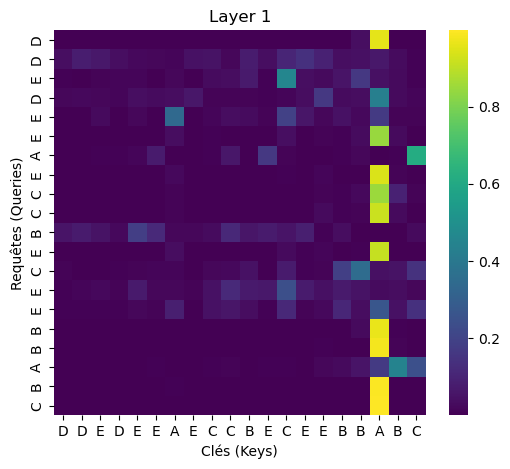

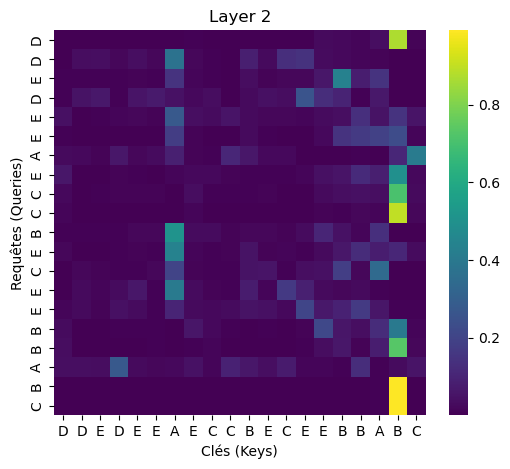

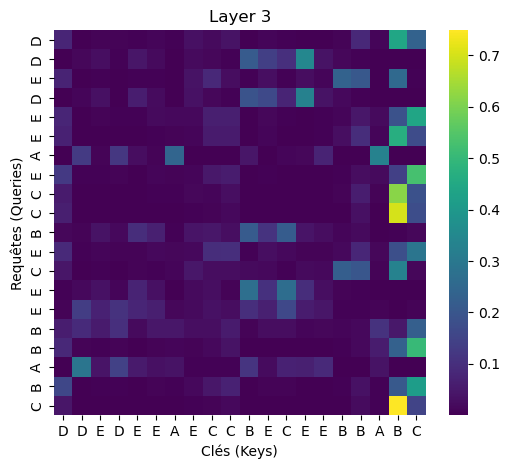

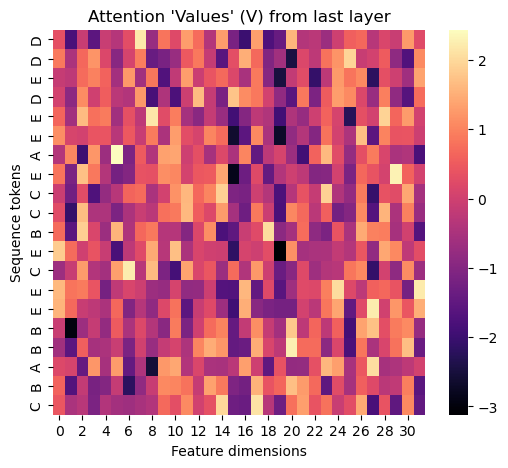

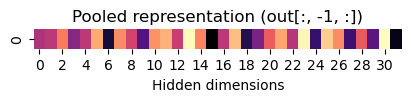

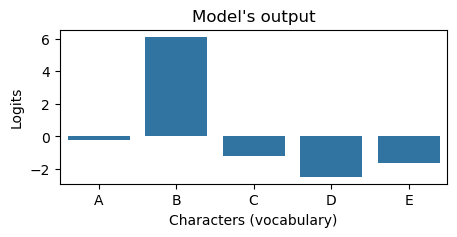

In [424]:
example_seq, label = ['D', 'D', 'E', 'D', 'E', 'E', 'A', 'E', 'C', 'C', 'B', 'E', 'C', 'E', 'E', 'B', 'B', 'A', 'B', 'C'], "B"
print(example_seq, label)

attn_maps = get_attention_weights(transfo, example_seq, CHAR_TO_IDX)
visualize_attention_weights(attn_maps, example_seq)

# visualize_token_representations(transfo, example_seq, CHAR_TO_IDX)

V = get_last_attention_values(transfo, example_seq, CHAR_TO_IDX)
visualize_attention_values(V, example_seq)

visualize_pooled_representation(transfo, example_seq, CHAR_TO_IDX)

visualize_model_output(transfo, example_seq, CHAR_TO_IDX)

In [393]:
transfo(seq_to_indices(example_seq, CHAR_TO_IDX))

tensor([[-0.2453,  6.1232, -1.2044, -2.4754, -1.6606]],
       grad_fn=<AddmmBackward0>)

La matrice affichée représente les poids d'attention :
$$A = \mathrm{softmax} \left( \frac{Q K^T}{\sqrt{d_k}} \right)$$
- chaque ligne représente une **query** ou **requête** (token qui "regarde");
- chaque colonne une **key** ou **clé** (token "regardé").
- chaque case $A_{ij}$ représente le **poids d’attention** de la query $i$ sur la key $j$.

> **La tête d’attention a appris à pointer directement sur le token D, car c’est lui qui détermine la réponse.**
> 
> **Dans ce cas, c'est la première requête (token B) qui contribue à la réponse.**
>

le modèle n’a pas besoin de "mémoriser" séquentiellement la position du dernier A, il apprend à "attendre" le dernier A et output le D qui vient après (dans ce cas).